**I recommend you run the first code cell of this notebook immediately, to start provisioning drake on the cloud machine, then you can leave this window open as you [read the textbook](manipulation.csail.mit.edu/pick.html).**

# Notebook setup

The following cell will:
- on Colab (only), install Drake to `/opt/drake`, install Drake's prerequisites via `apt`, and add pydrake to `sys.path`.  This will take approximately two minutes on the first time it runs (to provision the machine), but should only need to reinstall once every 12 hours.  If you navigate between notebooks using Colab's "File->Open" menu, then you can avoid provisioning a separate machine for each notebook.
- launch a server for our 3D visualizer (MeshCat) that will be used for the remainder of this notebook.

You will need to rerun this cell if you restart the kernel, but it should be fast because the machine will already have drake installed.

In [1]:
import importlib
import sys
from urllib.request import urlretrieve

# Install drake.
if 'google.colab' in sys.modules and importlib.util.find_spec('manipulation') is None:
    urlretrieve(f"http://manipulation.csail.mit.edu/scripts/setup/setup_manipulation_colab.py",
                "setup_manipulation_colab.py")
    from setup_manipulation_colab import setup_manipulation
    setup_manipulation(manipulation_sha='master', drake_version='20201019', drake_build='nightly')

# Determine if this notebook is currently running as a notebook or a unit test.
from IPython import get_ipython
running_as_notebook = get_ipython() and hasattr(get_ipython(), 'kernel')

# Use pyngrok on colab.
server_args = []
if 'google.colab' in sys.modules:
  server_args = ['--ngrok_http_tunnel']

# Start a single meshcat server instance to use for the remainder of this notebook.
from meshcat.servers.zmqserver import start_zmq_server_as_subprocess
proc, zmq_url, web_url = start_zmq_server_as_subprocess(server_args=server_args)

# Let's do all of our imports here, too.
import numpy as np
import ipywidgets
import pydrake.all
import os
from IPython.display import display

from pydrake.all import RigidTransform, RotationMatrix, RollPitchYaw
import pydrake.multibody.jupyter_widgets
import pydrake.systems.jupyter_widgets
from manipulation.utils import FindResource
from manipulation.jupyter_widgets import MakeJointSlidersThatPublishOnCallback

In [2]:
def AddPlanarBinAndCracker(plant):
    parser = pydrake.multibody.parsing.Parser(plant)
    bin = parser.AddModelFromFile(FindResource("models/planar_bin.sdf"))
    plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("bin_base", bin), RigidTransform(RotationMatrix.MakeZRotation(np.pi/2.0), [0,0,-0.015]))

    planar_joint_frame = plant.AddFrame(pydrake.multibody.tree.FixedOffsetFrame("planar_joint_frame", plant.world_frame(), RigidTransform(RotationMatrix.MakeXRotation(np.pi/2))))
    box = parser.AddModelFromFile(pydrake.common.FindResourceOrThrow("drake/manipulation/models/ycb/sdf/003_cracker_box.sdf"))
    box_frame = plant.AddFrame(pydrake.multibody.tree.FixedOffsetFrame("box_frame", plant.GetFrameByName("base_link_cracker", box), 
                                   RigidTransform(RotationMatrix.MakeXRotation(np.pi/2))))
    box_joint = plant.AddJoint(pydrake.multibody.tree.PlanarJoint("box_joint", planar_joint_frame, box_frame))
    box_joint.set_default_translation([0, 0.033400])
    return box

def AddPlanarBinAndSimpleBox(plant, mass=1.0, mu=1.0, width=0.2, depth=0.05, height=0.3):
    parser = pydrake.multibody.parsing.Parser(plant)
    bin = parser.AddModelFromFile(FindResource("models/planar_bin.sdf"))
    plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("bin_base", bin), RigidTransform(RotationMatrix.MakeZRotation(np.pi/2.0), [0,0,-0.015]))

    planar_joint_frame = plant.AddFrame(pydrake.multibody.tree.FixedOffsetFrame("planar_joint_frame", plant.world_frame(), RigidTransform(RotationMatrix.MakeXRotation(np.pi/2))))

    # TODO(russt): make this a *random* box?
    # TODO(russt): move random box to a shared py file.
    box_instance = plant.AddModelInstance("box")
    box_body = plant.AddRigidBody("box_body", box_instance, pydrake.multibody.tree.SpatialInertia(mass=mass, p_PScm_E=np.array([0., 0., 0.]),
            G_SP_E=pydrake.multibody.tree.UnitInertia.SolidBox(width, depth, height)))
    if plant.geometry_source_is_registered():
        plant.RegisterCollisionGeometry(box_body, RigidTransform(), pydrake.geometry.Box(width-0.001, depth-0.001, height=0.001), "box_body", pydrake.multibody.plant.CoulombFriction(mu, mu))
        i=0
        for x in [-width/2.0, width/2.0]:
            for y in [-depth/2.0, depth/2.0]:
                for z in [-height/2.0, height/2.0]:
                    plant.RegisterCollisionGeometry(box_body, RigidTransform([x, y, z]), pydrake.geometry.Sphere(radius=1e-7), f"contact_sphere{i}", pydrake.multibody.plant.CoulombFriction(mu, mu))
                    i += 1
        plant.RegisterVisualGeometry(box_body, RigidTransform(), pydrake.geometry.Box(width, depth, height), "box_body", [.5, .5, .9, 1.0])
    box_joint = plant.AddJoint(pydrake.multibody.tree.PlanarJoint("box_joint", planar_joint_frame, box_body.body_frame()))
    box_joint.set_default_translation([0, height/2.0])
    return box_instance


def AddPlanarGripper(plant):
    parser = pydrake.multibody.parsing.Parser(plant)
    parser.package_map().Add("wsg_50_description", os.path.dirname(pydrake.common.FindResourceOrThrow("drake/manipulation/models/wsg_50_description/package.xml")))
    gripper = parser.AddModelFromFile(FindResource("models/schunk_wsg_50_welded_fingers.sdf"), "gripper")
    gripper_body = plant.GetBodyByName("body", gripper)

    # Add a planar joint the old fashioned way (so that I can have three actuators):
    gripper_false_body1 = plant.AddRigidBody("false_body1", gripper, pydrake.multibody.tree.SpatialInertia(0, [0,0,0], pydrake.multibody.tree.UnitInertia(0,0,0)))
    gripper_false_body2 = plant.AddRigidBody("false_body2", gripper, pydrake.multibody.tree.SpatialInertia(0, [0,0,0], pydrake.multibody.tree.UnitInertia(0,0,0)))
    gripper_x = plant.AddJoint(pydrake.multibody.tree.PrismaticJoint("gripper_x", plant.world_frame(), plant.GetFrameByName("false_body1"), [1, 0, 0], -.3, .3))
    plant.AddJointActuator("gripper_x", gripper_x)
    gripper_z = plant.AddJoint(pydrake.multibody.tree.PrismaticJoint("gripper_z", plant.GetFrameByName("false_body1"), plant.GetFrameByName("false_body2"), [0, 0, 1], 0.0, 0.5))
    gripper_z.set_default_translation(0.3)
    plant.AddJointActuator("gripper_z", gripper_z)
    gripper_frame = plant.AddFrame(pydrake.multibody.tree.FixedOffsetFrame("gripper_frame", plant.GetFrameByName("body", gripper), 
                                    RigidTransform(RotationMatrix.MakeXRotation(np.pi/2))))
    gripper_theta = plant.AddJoint(pydrake.multibody.tree.RevoluteJoint("gripper_theta", plant.GetFrameByName("false_body2"), gripper_frame, [0, -1, 0],  -np.pi, np.pi))
    plant.AddJointActuator("gripper_theta", gripper_theta)

    return gripper

def MakePlanarGripperOnlyPlant():
    plant = pydrake.multibody.plant.MultibodyPlant(time_step=0.005)
    AddPlanarGripper(plant)
    plant.Finalize()
    return plant

def AddPointFinger(plant):
    mu = 1.0
    finger = plant.AddModelInstance("finger")
    false_body1 = plant.AddRigidBody("false_body1", finger, pydrake.multibody.tree.SpatialInertia(0, [0,0,0], pydrake.multibody.tree.UnitInertia(0,0,0)))
    finger_body = plant.AddRigidBody("body", finger, pydrake.multibody.tree.SpatialInertia(mass=1.0, p_PScm_E=np.array([0., 0., 0.]),
            G_SP_E=pydrake.multibody.tree.UnitInertia(1.0, 1.0, 1.0)))
    shape = pydrake.geometry.Sphere(0.01)
    if plant.geometry_source_is_registered():
        plant.RegisterCollisionGeometry(finger_body, RigidTransform(), shape, "body", pydrake.multibody.plant.CoulombFriction(mu, mu))
        plant.RegisterVisualGeometry(finger_body, RigidTransform(), shape, "body", [.9, .5, .5, 1.0])
    finger_x = plant.AddJoint(pydrake.multibody.tree.PrismaticJoint("finger_x", plant.world_frame(), plant.GetFrameByName("false_body1"), [1, 0, 0], -.3, .3))
    plant.AddJointActuator("finger_x", finger_x)
    finger_z = plant.AddJoint(pydrake.multibody.tree.PrismaticJoint("finger_z", plant.GetFrameByName("false_body1"), plant.GetFrameByName("body"), [0, 0, 1], 0.0, 0.5))
    finger_z.set_default_translation(0.25)
    plant.AddJointActuator("finger_z", finger_z)

    return finger

def MakeFingerOnlyPlant():
    plant = pydrake.multibody.plant.MultibodyPlant(time_step=0.005)
    AddPointFinger(plant)
    plant.Finalize()
    return plant


class PointFingerForceControl(pydrake.systems.framework.LeafSystem):

    def __init__(self, plant):
        pydrake.systems.framework.LeafSystem.__init__(self)
        self._plant = plant

        self.DeclareVectorInputPort(
            "desired_contact_force", pydrake.systems.framework.BasicVector(2))
        self.DeclareVectorOutputPort(
            "finger_actuation", pydrake.systems.framework.BasicVector(2), 
                                    self.CalcOutput)

    def CalcOutput(self, context, output):
        finger_mass = 1
        g = self._plant.gravity_field().gravity_vector()[[0,2]]

        desired_force = self.get_input_port(0).Eval(context)
        output.SetFromVector(-finger_mass*g - desired_force)


# TODO(russt): Move this to a shared py file.
def SetTransparency(scene_graph, alpha, source_id, geometry_ids=None):
    inspector = scene_graph.model_inspector()
    if not geometry_ids:
        geometry_ids = inspector.GetAllGeometryIds()

    for gid in geometry_ids:
        # TODO: Add this binding
#        if not inspector.BelongsToSource(gid, source_id):
#            continue
        props = inspector.GetIllustrationProperties(gid)
        if props is None or not props.HasProperty("phong", "diffuse"):
            continue
        c = props.GetProperty("phong", "diffuse")
        new_color = pydrake.geometry.Rgba(c.r(), c.g(), c.b(), alpha)
        props.UpdateProperty("phong", "diffuse", new_color)

# TODO(russt): Move this to a shared py file.
def SetColor(scene_graph, color, source_id, geometry_ids=None):
    inspector = scene_graph.model_inspector()
    if not geometry_ids:
        geometry_ids = inspector.GetAllGeometryIds()

    for gid in geometry_ids:
        # TODO: Add this binding
#        if not inspector.BelongsToSource(gid, source_id):
#            continue
        props = inspector.GetIllustrationProperties(gid)
        if props is None or not props.HasProperty("phong", "diffuse"):
            continue
        new_color = pydrake.geometry.Rgba(color[0], color[1], color[2], color[3])
        props.UpdateProperty("phong", "diffuse", new_color)


# Commanding a constant force

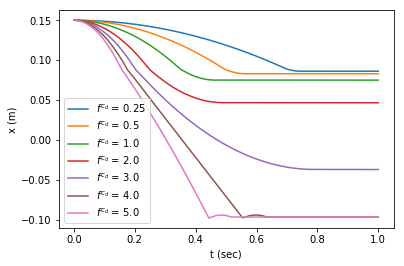

In [3]:
import matplotlib.pyplot as plt

def force_control_point_finger(desired_horizontal_forces=[4.0], duration=1.0, draw=False):
    builder = pydrake.systems.framework.DiagramBuilder()

    plant, scene_graph = pydrake.multibody.plant.AddMultibodyPlantSceneGraph(builder, time_step=0.001)
    box = AddPlanarBinAndCracker(plant)
    finger = AddPointFinger(plant)
    plant.GetJointByName("finger_x").set_default_translation(0.15)
    plant.GetJointByName("finger_z").set_default_translation(0.05)
    plant.Finalize()

    if draw:
        vis = pydrake.systems.meshcat_visualizer.ConnectMeshcatVisualizer(builder, scene_graph, delete_prefix_on_load=False)
        vis.vis['drake']['4'].delete()  # Only flush the gripper geometry.
    #    vis.set_planar_viewpoint(xmin=-.5, xmax=.5, ymin=-0.1, ymax=0.6)
        contact_visualizer = builder.AddSystem(pydrake.systems.meshcat_visualizer.MeshcatContactVisualizer(vis, plant=plant, contact_force_radius=0.005))
        builder.Connect(plant.get_contact_results_output_port(),
                        contact_visualizer.GetInputPort("contact_results"))

    controller = builder.AddSystem(PointFingerForceControl(plant))
    builder.Connect(controller.get_output_port(), plant.get_actuation_input_port())
    builder.ExportInput(controller.get_input_port(), "desired_contact_force")

    log = pydrake.systems.primitives.LogOutput(plant.get_state_output_port(finger), builder)

    diagram = builder.Build()

    plt.figure()
    lines = []
    for f in desired_horizontal_forces:
        log.reset()
        simulator = pydrake.systems.analysis.Simulator(diagram)
        context = simulator.get_mutable_context()
        diagram.get_input_port().FixValue(context, [f, 0])

        simulator.AdvanceTo(duration)
        t = log.sample_times()
        x = log.data()
        lines.append(plt.plot(t, x[0, :])[0])

    plt.legend(lines, [("$f^{c_d}$ = " + str(f)) for f in desired_horizontal_forces])
    plt.xlabel('t (sec)')
    plt.ylabel('x (m)')

force_control_point_finger([0.25, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0])


#  A force-based flip-up strategy

In [4]:
from ipywidgets import FloatSlider, Layout

def force_control_point_finger(teleop=True):
    builder = pydrake.systems.framework.DiagramBuilder()

    plant, scene_graph = pydrake.multibody.plant.AddMultibodyPlantSceneGraph(builder, time_step=0.001)
    box = AddPlanarBinAndCracker(plant)
    finger = AddPointFinger(plant)
    plant.GetJointByName("finger_x").set_default_translation(0.15)
    plant.GetJointByName("finger_z").set_default_translation(0.025)
    plant.Finalize()

    vis = pydrake.systems.meshcat_visualizer.ConnectMeshcatVisualizer(builder, scene_graph, delete_prefix_on_load=False)
    vis.vis['drake']['4'].delete()  # Only flush the gripper geometry.
    #vis.set_planar_viewpoint(xmin=-.5, xmax=.5, ymin=-0.1, ymax=0.6)
    contact_visualizer = builder.AddSystem(pydrake.systems.meshcat_visualizer.MeshcatContactVisualizer(vis, plant=plant, contact_force_radius=0.005, contact_force_scale=40.0))
    builder.Connect(plant.get_contact_results_output_port(),
                    contact_visualizer.GetInputPort("contact_results"))

    class RotateBoxOnTopCorner(pydrake.systems.framework.LeafSystem):

        def __init__(self, plant):
            pydrake.systems.framework.LeafSystem.__init__(self)
            self._plant = plant

            # One state variable for the integral error.
            self.DeclareContinuousState(1)

            self.DeclareVectorInputPort("desired_box_angle",
                pydrake.systems.framework.BasicVector(1))
            self.DeclareVectorInputPort(
                "box_state", pydrake.systems.framework.BasicVector(6))
            self.DeclareVectorInputPort(
                "finger_state", pydrake.systems.framework.BasicVector(4))
            self.DeclareVectorOutputPort(
                "finger_force", pydrake.systems.framework.BasicVector(2), 
                                        self.CalcOutput)

        def DoCalcTimeDerivatives(self, context, derivatives):
            # Compute integral of the angle error.
            theta_desired = self.get_input_port(0).Eval(context)[0]
            theta = self.get_input_port(1).Eval(context)[2]
            derivatives.get_mutable_vector().SetFromVector([theta_desired - theta])

        def CalcOutput(self, context, output):
            box_mass = 0.411  # Let's revisit whether we need this!
            mu_A = 1.0
            mu_C = 1.0
            g = -self._plant.gravity_field().gravity_vector()[2]

            theta_desired = self.get_input_port(0).Eval(context)[0]
            box_state = self.get_input_port(1).Eval(context)
            theta = box_state[2]
            theta_dot = box_state[5]

            R_WC = np.array([[-np.sin(theta), -np.cos(theta)], [np.cos(theta), -np.sin(theta)]])
            R_CW = R_WC.T
            finger_state = self.get_input_port(2).Eval(context)

            prog = pydrake.solvers.mathematicalprogram.MathematicalProgram()
            f_C_W = prog.NewContinuousVariables(2, "f_C_W")  # force from finger to box
            f_C_C = np.matmul(R_CW, f_C_W)

            # PID control on f_CC[1]
            kp = 100.0
            ki = 1.0
            kd = 2.0*np.sqrt(kp)  # should really be kp*I on inside
            integral_error = context.get_continuous_state_vector().GetAtIndex(0)
            pid = kp*(theta_desired - theta) + ki*integral_error - kd*theta_dot
            prog.AddCost((f_C_C[0] - pid)**2)

            prog.AddConstraint(f_C_W[0] <= mu_A * (box_mass*g - f_C_W[1]))
            prog.AddConstraint(-f_C_W[0] <= mu_A * (box_mass*g - f_C_W[1]))
            prog.AddConstraint(f_C_C[1] >= 0.1)  # To ensure I make and stay in contact.
            prog.AddConstraint(f_C_C[0] <= mu_C * f_C_C[1])
            prog.AddConstraint(-f_C_C[0] <= mu_C * f_C_C[1])

            result = pydrake.solvers.mathematicalprogram.Solve(prog)
            
            if not result.is_success():
                print(result.GetInfeasibleConstraintNames(prog))
                output.SetFromVector([0, 0])
                return
            
            f_C_W = result.GetSolution(f_C_W)
            output.SetFromVector(-f_C_W)


    controller = builder.AddSystem(PointFingerForceControl(plant))
    builder.Connect(controller.get_output_port(), plant.get_actuation_input_port())

    rotate_box = builder.AddSystem(RotateBoxOnTopCorner(plant))
    builder.Connect(rotate_box.get_output_port(), controller.get_input_port())
    builder.Connect(plant.get_state_output_port(box), rotate_box.get_input_port(1))
    builder.Connect(plant.get_state_output_port(finger), rotate_box.get_input_port(2))

    if teleop:
        slider = FloatSlider(value=0, min=0, max=np.pi/2, step=0.05, continuous_update=True, description="desired_box_angle", layout=Layout(width="'100'"))
        teleop = builder.AddSystem(pydrake.systems.jupyter_widgets.WidgetSystem([slider]))
        builder.Connect(teleop.get_output_port(), rotate_box.get_input_port(0)) 
    else:
        theta_trajectory = pydrake.trajectories.PiecewisePolynomial.FirstOrderHold(
            [0, 2, 20], [[0, 0, np.pi/2.0]])
        trajectory_source = builder.AddSystem(pydrake.systems.primitives.TrajectorySource(theta_trajectory))
        builder.Connect(trajectory_source.get_output_port(), rotate_box.get_input_port(0))

    diagram = builder.Build()
    simulator = pydrake.systems.analysis.Simulator(diagram)

    if not running_as_notebook:
        simulator.AdvanceTo(0.01)
    elif teleop:
        stop_button = ipywidgets.ToggleButton(value=False, description='Stop Simulation')
        display(stop_button)
        while not stop_button.value:
            simulator.AdvanceTo(simulator.get_context().get_time() + 2.0)
        stop_button.value = False
    else:
        simulator.set_target_realtime_rate(.5)  # slow motion!
        vis.start_recording()
        simulator.AdvanceTo(theta_trajectory.end_time())
        vis.stop_recording()
        vis.vis['drake/contact_forces'].delete()  # TODO: make my recording include the contact forces!
        vis.publish_recording()

force_control_point_finger(teleop=False)

Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6000...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/
Connected to meshcat-server.


/opt/drake/lib/python3.6/site-packages/pydrake/systems/meshcat_visualizer.py:650: RuntimeWarning: invalid value encountered in arcsin
  np.arcsin(np.linalg.norm(angle_axis)), angle_axis)


# Teleop with Impedance Control


In [5]:
def teleop_box_pickup(point_finger=True):
    builder = pydrake.systems.framework.DiagramBuilder()

    plant, scene_graph = pydrake.multibody.plant.AddMultibodyPlantSceneGraph(builder, time_step=0.001)
    AddPlanarBinAndSimpleBox(plant)
#    AddPlanarBinAndCracker(plant)
    SetTransparency(scene_graph, alpha=0.5, source_id=plant.get_source_id())

    gripper = AddPointFinger(plant) if point_finger else AddPlanarGripper(plant)
    plant.Finalize()

    vis = pydrake.systems.meshcat_visualizer.ConnectMeshcatVisualizer(builder, scene_graph, delete_prefix_on_load=False)
    vis.vis['drake']['4'].delete()  # Only flush the gripper geometry.
    #vis.set_planar_viewpoint(xmin=-.5, xmax=.5, ymin=-0.1, ymax=0.6)
    contact_visualizer = builder.AddSystem(pydrake.systems.meshcat_visualizer.MeshcatContactVisualizer(vis, plant=plant, contact_force_radius=0.005, contact_force_scale=40.0))
    builder.Connect(plant.get_contact_results_output_port(),
                    contact_visualizer.GetInputPort("contact_results"))


    # Use the controller plant to visualize the set point geometry.
    controller_scene_graph = builder.AddSystem(pydrake.geometry.SceneGraph())
    controller_plant = pydrake.multibody.plant.MultibodyPlant(time_step=0.005)
    controller_plant.RegisterAsSourceForSceneGraph(controller_scene_graph)
    AddPointFinger(controller_plant) if point_finger else AddPlanarGripper(controller_plant)
    controller_plant.Finalize()
    SetColor(controller_scene_graph, color=[1.0, 165.0/255, 0.0, 1.0], source_id=plant.get_source_id())
    controller_vis = pydrake.systems.meshcat_visualizer.ConnectMeshcatVisualizer(builder, controller_scene_graph, prefix="controller", delete_prefix_on_load=False)
    controller_vis.set_name("controller meshcat")
    controller_vis.vis['controller']['2'].delete()  # Only flush the gripper geometry.

    N = controller_plant.num_positions()
    kp = [100]*N
    ki = [1]*N
    kd = [2*np.sqrt(kp[0])]*N
    controller = builder.AddSystem(pydrake.systems.controllers.InverseDynamicsController(controller_plant, kp, ki, kd, False))
    builder.Connect(plant.get_state_output_port(gripper), controller.get_input_port_estimated_state())

    display(ipywidgets.Label(value="Set desired positions:"))
    position_sliders = builder.AddSystem(pydrake.multibody.jupyter_widgets.JointSliders(controller_plant))
    positions_to_state = builder.AddSystem(pydrake.systems.primitives.Multiplexer([N, N]))
    builder.Connect(position_sliders.get_output_port(), positions_to_state.get_input_port(0))
    zeros = builder.AddSystem(pydrake.systems.primitives.ConstantVectorSource([0]*N))
    builder.Connect(zeros.get_output_port(0), positions_to_state.get_input_port(1))
    builder.Connect(positions_to_state.get_output_port(), controller.get_input_port_desired_state())

    positions_to_poses = builder.AddSystem(pydrake.systems.rendering.MultibodyPositionToGeometryPose(controller_plant))
    builder.Connect(position_sliders.get_output_port(), positions_to_poses.get_input_port())
    builder.Connect(positions_to_poses.get_output_port(), controller_scene_graph.get_source_pose_port(controller_plant.get_source_id()))

    display(ipywidgets.Label(value="Set feedforward forces/torques:"))
    force_sliders = builder.AddSystem(pydrake.multibody.jupyter_widgets.JointSliders(controller_plant))
    for slider in force_sliders._slider:
        slider.min = -1.0
        slider.max = 1.0
        slider.value = 0.0
#
    adder = builder.AddSystem(pydrake.systems.primitives.Adder(2, N))
    builder.Connect(controller.get_output_port(), adder.get_input_port(0))
    builder.Connect(force_sliders.get_output_port(), adder.get_input_port(1))
    builder.Connect(adder.get_output_port(), plant.get_actuation_input_port())
#    builder.Connect(controller.get_output_port(), plant.get_actuation_input_port())

    diagram = builder.Build()
    simulator = pydrake.systems.analysis.Simulator(diagram)

    if running_as_notebook:
        stop_button = ipywidgets.ToggleButton(value=False, description='Stop Simulation')
        display(stop_button)
        while not stop_button.value:
            simulator.AdvanceTo(simulator.get_context().get_time() + 2.0)
        stop_button.value = False
    else:
        simulator.AdvanceTo(0.01)

teleop_box_pickup(point_finger=False)

Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6000...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/
Connected to meshcat-server.
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6000...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/
Connected to meshcat-server.


Label(value='Set desired positions:')

FloatSlider(value=0.0, description='gripper_x', layout=Layout(width="'200'"), max=0.3, min=-0.3, step=0.01, st…

FloatSlider(value=0.3, description='gripper_z', layout=Layout(width="'200'"), max=0.5, step=0.01, style=Slider…

FloatSlider(value=0.0, description='gripper_theta', layout=Layout(width="'200'"), max=3.141592653589793, min=-…

Label(value='Set feedforward forces/torques:')

FloatSlider(value=0.0, description='gripper_x', layout=Layout(width="'200'"), max=0.3, min=-0.3, step=0.01, st…

FloatSlider(value=0.3, description='gripper_z', layout=Layout(width="'200'"), max=0.5, step=0.01, style=Slider…

FloatSlider(value=0.0, description='gripper_theta', layout=Layout(width="'200'"), max=3.141592653589793, min=-…

ToggleButton(value=False, description='Stop Simulation')

In [7]:
def stiffness_box_flipup():
    builder = pydrake.systems.framework.DiagramBuilder()

    plant, scene_graph = pydrake.multibody.plant.AddMultibodyPlantSceneGraph(builder, time_step=0.001)
    AddPlanarBinAndSimpleBox(plant)
    SetTransparency(scene_graph, alpha=0.5, source_id=plant.get_source_id())

    gripper = AddPointFinger(plant)
    plant.GetJointByName("finger_x").set_default_translation(0.15)
    plant.GetJointByName("finger_z").set_default_translation(0.025)
    plant.Finalize()

    vis = pydrake.systems.meshcat_visualizer.ConnectMeshcatVisualizer(builder, scene_graph)
    vis.set_planar_viewpoint(xmin=-.5, xmax=.5, ymin=-0.1, ymax=0.6)
    contact_visualizer = builder.AddSystem(pydrake.systems.meshcat_visualizer.MeshcatContactVisualizer(vis, plant=plant, contact_force_radius=0.005, contact_force_scale=40.0))
    builder.Connect(plant.get_contact_results_output_port(),
                    contact_visualizer.GetInputPort("contact_results"))

    # Use the controller plant to visualize the set point geometry.
    controller_scene_graph = builder.AddSystem(pydrake.geometry.SceneGraph())
    controller_plant = pydrake.multibody.plant.MultibodyPlant(time_step=0.005)
    controller_plant.RegisterAsSourceForSceneGraph(controller_scene_graph)
    AddPointFinger(controller_plant)
    controller_plant.Finalize()
    SetColor(controller_scene_graph, color=[1.0, 165.0/255, 0.0, 1.0], source_id=plant.get_source_id())
    controller_vis = pydrake.systems.meshcat_visualizer.ConnectMeshcatVisualizer(builder, controller_scene_graph, prefix="controller", delete_prefix_on_load=False)
    controller_vis.set_name("controller meshcat")
    controller_vis.vis['controller']['2'].delete()  # Only flush the gripper geometry.

    # TODO: Implement the proper JointStiffnessController in drake and use it here.
    # (For a point finger with unit mass, the InverseDynamicsController is identical)
    N = controller_plant.num_positions()
    kp = [100]*N
    ki = [1]*N
    kd = [2*np.sqrt(kp[0])]*N
    controller = builder.AddSystem(pydrake.systems.controllers.InverseDynamicsController(controller_plant, kp, ki, kd, False))
    builder.Connect(plant.get_state_output_port(gripper), controller.get_input_port_estimated_state())

    traj = pydrake.trajectories.PiecewisePolynomial.FirstOrderHold([0, 10.0, 20.0], np.array([[.15, .025], [-.25, .025], [-.25, 0.125]]).T)
    traj_system = builder.AddSystem(pydrake.systems.primitives.TrajectorySource(traj))
    positions_to_state = builder.AddSystem(pydrake.systems.primitives.Multiplexer([N, N]))
    builder.Connect(traj_system.get_output_port(), positions_to_state.get_input_port(0))
    zeros = builder.AddSystem(pydrake.systems.primitives.ConstantVectorSource([0]*N))
    builder.Connect(zeros.get_output_port(0), positions_to_state.get_input_port(1))
    builder.Connect(positions_to_state.get_output_port(), controller.get_input_port_desired_state())

    positions_to_poses = builder.AddSystem(pydrake.systems.rendering.MultibodyPositionToGeometryPose(controller_plant))
    builder.Connect(traj_system.get_output_port(), positions_to_poses.get_input_port())
    builder.Connect(positions_to_poses.get_output_port(), controller_scene_graph.get_source_pose_port(controller_plant.get_source_id()))
    builder.Connect(controller.get_output_port(), plant.get_actuation_input_port())

    diagram = builder.Build()
    simulator = pydrake.systems.analysis.Simulator(diagram)

    if running_as_notebook:
        simulator.AdvanceTo(traj.end_time()+0.5)
    else:
        simulator.AdvanceTo(0.01)

stiffness_box_flipup()

Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6000...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/
Connected to meshcat-server.
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6000...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/
Connected to meshcat-server.
